In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import precision_score, recall_score,precision_recall_curve

In [0]:
df = pd.read_csv('MIMIC.csv')
df.iloc[:, 1:] = preprocessing.MinMaxScaler().fit_transform(df.iloc[:, 1:])

print(df.shape)
print(df.columns)
print(Counter(df['Label'].values))

(12691, 137)
Index(['Label', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8',
       ...
       'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134',
       'X135'],
      dtype='object', length=137)
Counter({0: 11096, 1: 1595})


In [0]:
#Preparing holdout set
posCount= 600
holdout_pos = df[df['Label']==1].sample(n=posCount, random_state=1)
#print(holdout_pos.head())
df = df.drop(holdout_pos.index)

negCount= 2400
holdout_neg = df[df['Label']==0].sample(n=negCount, random_state=1)

df = df.drop(holdout_neg.index)
holdout = pd.concat([holdout_pos, holdout_neg])

print(df.shape)
print(holdout.shape)

(9691, 137)
(3000, 137)


In [0]:
X_test = holdout.iloc[:, 1:].values
y_test = holdout['Label'].values
print(Counter(y_test))

X_train = df.iloc[:, 1:].values
y_train = df['Label'].values
print(Counter(y_train))

Counter({0: 2400, 1: 600})
Counter({0: 8696, 1: 995})


In [0]:
nEpochs = 10
nBatch= 50
inputDim = X_train.shape[1] # Count of features

In [0]:
model = Sequential()

model.add(Dense(64, input_dim=inputDim, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

#model.summary()

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

# Fiting the model 
hist = model.fit(X_train, y_train,
          validation_split=0.2, 
          epochs=nEpochs, 
          batch_size=nBatch,
          verbose=1)

Train on 7752 samples, validate on 1939 samples
Epoch 1/10
7752/7752 [==============================] - 1s 101us/step - loss: 0.3371 - accuracy: 0.8885 - val_loss: 0.2877 - val_accuracy: 0.8881
Epoch 2/10
7752/7752 [==============================] - 1s 74us/step - loss: 0.2753 - accuracy: 0.9011 - val_loss: 0.2759 - val_accuracy: 0.8922
Epoch 3/10
7752/7752 [==============================] - 1s 70us/step - loss: 0.2670 - accuracy: 0.9013 - val_loss: 0.2728 - val_accuracy: 0.8927
Epoch 4/10
7752/7752 [==============================] - 1s 72us/step - loss: 0.2641 - accuracy: 0.9029 - val_loss: 0.2692 - val_accuracy: 0.8922
Epoch 5/10
7752/7752 [==============================] - 1s 70us/step - loss: 0.2604 - accuracy: 0.9036 - val_loss: 0.2683 - val_accuracy: 0.8901
Epoch 6/10
7752/7752 [==============================] - 1s 74us/step - loss: 0.2597 - accuracy: 0.9009 - val_loss: 0.2684 - val_accuracy: 0.8886
Epoch 7/10
7752/7752 [==============================] - 1s 71us/step - loss: 0.25

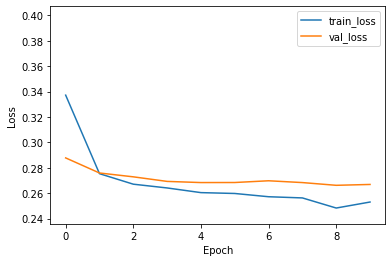

In [0]:
#Plotting model loss
hist_df = pd.DataFrame(hist.history)
#print(hist_df)

plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.ylim(.95*hist_df[1:].values.min(), 0.45*hist_df[1:].values.max())
plt.savefig('Loss.png', dpi=600, quality=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


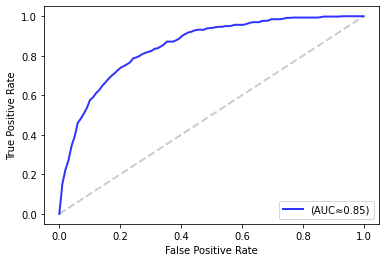

In [0]:
#Plotting ROC curve
predictions = model.predict(X_test)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
 
fpr, tpr, thresholds = roc_curve(y_test, predictions)

tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0

# Drawing line from origin represnting random predictions
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',alpha=0.2)

#Adding to ROC plot
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'(AUC≈%0.2f)' % (mean_auc),
         lw=2, alpha=0.8)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.title('ROC Curve')
#plt.show()
plt.savefig('ROC.png', dpi=600, quality=100)


0.2
0.5984262891190066


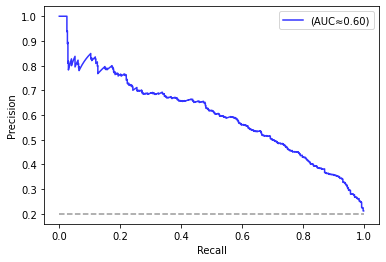

In [0]:
#Plotting Precision-Recall curve
randomLine = len(y_test[y_test==1]) / len(y_test)
print(randomLine)
plt.plot([0, 1], [randomLine, randomLine], linestyle='--', alpha=0.8, color='gray')

#plot the model precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
auc_score = auc(recall, precision)
print(auc_score)

plt.plot(recall, precision, alpha=0.8, color='blue', label='(AUC≈%0.2f)' % (auc_score))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.savefig('Pr-Rec.png', dpi=600, quality=100)